# Exploring similarity of areas in the UK

## Introduction


The current pandemic has changed our lifestyle in many ways. One newly adopted norm is working from home. This means that employees don't have to be close to their workplace anymore. Residents in the UK may want to explore other parts of the country that are similar to their current area. This project aims to help them to identify similar areas in the UK based on what amenities area available in the area.

## Data

To explore the similarities between areas in the UK, I use the data provided by freemaptools [here](https://www.freemaptools.com/download-uk-postcode-lat-lng.htm). This downloaded csv file contains a list of all the postcodes and corresponding latitudes and longitudes of areas in the UK. I also use Wikipedia for information on the names of the areas from [here](https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom).

Before we get the data and start exploring it, let's download all the dependencies that we will need.


## Methodology

In [ ]:
!pip install geopy

In [1]:
import os # library for file path

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re # to handle regex

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


### 1. Download and Explore Dataset


In [2]:
# path
notebook_path = os.path.abspath("UK_Area_Similarity_Capstone_Project.ipynb")
path=notebook_path.rsplit('/',1)
path=path[0]+'/'

Get postcode with latitude and longitude information

In [3]:
file = 'ukpostcodes.csv' # downloaded csv file from internet
df = pd.read_csv(path+file)
df.head()

id  postcode   latitude  longitude
0   1  AB10 1XG  57.144165  -2.114848
1   2  AB10 6RN  57.137880  -2.121487
2   3  AB10 7JB  57.124274  -2.127190
3   4  AB11 5QN  57.142701  -2.093295
4   5  AB11 6UL  57.137547  -2.112233

In [4]:
file = 'ukpostcodes.csv' # downloaded csv file from internet
df = pd.read_csv(path+file)
df = df.drop(['id'],axis=1)
df['AreaCode'] = df['postcode'].apply(lambda x: x.split(' ')[0])
df = df.groupby(['AreaCode']).mean()
df['AreaCode'] = df.index
df.index = range(df.shape[0])
df.columns = ['Latitude','Longitude','Postcode']
print(df.shape)
df.head()

(2979, 3)


Latitude  Longitude Postcode
0  57.135204  -2.120402     AB10
1  57.139148  -2.092871     AB11
2  57.102113  -2.112707     AB12
3  57.107919  -2.237453     AB13
4  57.100449  -2.271324     AB14

Get area name by webscraping

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom' # Wikipedia page
AreaName = pd.read_html(url) # gets all tables in this page

In [32]:
AreaName_df = AreaName[0]
AreaName_df['Area name'] = AreaName_df['Postcode area name[1][3]'].apply(lambda x: x.split('[')[0])
AreaName_df = AreaName_df.drop(['Postcode area name[1][3]','Code formation'],axis=1)
MissingPC = [['IM','Isle of Man'],['GY','Guernsey'],['JE','Jersey']]
for i,v in enumerate(MissingPC):
    AreaName_df.loc[AreaName_df.shape[0]+i] = [v[0],v[1]]
print(AreaName_df.shape)
AreaName_df.head()

(124, 2)


Postcode area   Area name
0            AB    Aberdeen
1            AL   St Albans
2             B  Birmingham
3            BA        Bath
4            BB   Blackburn

Mapping postcode with area name

In [7]:
AreaName_dict = {row['Postcode area']:row['Area name'] for ind,row in AreaName_df.iterrows()}

In [8]:
def MapAreaName(pc):
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    m = r.match(pc)
    if m==None: 
        return ""
    else: 
        m.group(1)
        return AreaName_dict[m.group(1)]

In [9]:
df['Area Name'] = df['Postcode'].apply(lambda x: MapAreaName(x))
df = df[df['Area Name']!=""]
df = df[df['Latitude'].notna()]
#df = df[df['Postcode']!='BN95']
print(df.shape)
df.head()

(2977, 4)


Latitude  Longitude Postcode Area Name
0  57.135204  -2.120402     AB10  Aberdeen
1  57.139148  -2.092871     AB11  Aberdeen
2  57.102113  -2.112707     AB12  Aberdeen
3  57.107919  -2.237453     AB13  Aberdeen
4  57.100449  -2.271324     AB14  Aberdeen

#### Use geopy library to get the latitude and longitude values

In order to define an instance of the geocoder, we need to define a user_agent. 

In [10]:
address = 'United Kingdom'

geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of United Kingdom are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of United Kingdom are 54.7023545, -3.2765753.


#### Create a map of the UK with areas superimposed on top.

In [11]:
# create map using latitude and longitude values
map_uk = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, postcode, area in zip(df['Latitude'], df['Longitude'], df['Postcode'], df['Area Name']):
    label = '{}, {}'.format(area, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  
    
map_uk

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [ ]:
CLIENT_ID = 'ALIKOUIHINWH1VM14HKXTIQRZSICDPU1MJ1FES3HRYM1A4QK' # your Foursquare ID
CLIENT_SECRET = 'ZEYSWFPTFD1CU4QSV3BJBAS5ACNNJHCLU3ZYU0A1WLJYNMPZ' # your Foursquare Secret
ACCESS_TOKEN = 'POSO4Z0CPAZCUVNX4RTU13KSZNR34O2FBGMXTEPTFF15TW33' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [ ]:
df.loc[0, 'Postcode']

Get the neighborhood's latitude and longitude values.


In [ ]:
uk_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
uk_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

uk_postcode = df.loc[0, 'Postcode'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(uk_postcode, 
                                                               uk_latitude, 
                                                               uk_longitude))

#### Now, let's get the top 100 venues that are in AB10 within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [ ]:
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    uk_latitude, 
    uk_longitude, 
    radius, 
    LIMIT)
url # display URL


Send the GET request and examine the resutls


In [ ]:
results = requests.get(url).json()
results

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

And how many venues were returned by Foursquare?


In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

In [ ]:
nearby_venues

<a id='item2'></a>


### 2. Explore areas in the UK


#### Let's create a function to repeat the same process to all the areas in the UK


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe


In [ ]:
UK_Venues = getNearbyVenues(names=df['Postcode'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [ ]:
UK_Venues.to_csv(path+'UK_Venues.csv',index=False,header=True)

In [12]:
import pandas as pd

# path
notebook_path = os.path.abspath("UK_Area_Similarity_Capstone_Project.ipynb")
path=notebook_path.rsplit('/',1)
path=path[0]+'/'

UK_Venues = pd.read_csv(path+'UK_Venues.csv')

#### Let's check the size of the resulting dataframe


In [13]:
print(UK_Venues.shape)
UK_Venues.head()

(8070, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         AB10              57.135204               -2.120402   
1         AB10              57.135204               -2.120402   
2         AB10              57.135204               -2.120402   
3         AB10              57.135204               -2.120402   
4         AB10              57.135204               -2.120402   

                                      Venue  Venue Latitude  Venue Longitude  \
0                     Hass's Fish And Chips       57.138142        -2.114179   
1                            Maggie's Grill       57.137788        -2.114346   
2  Atlantis Restaurant at The Mariner Hotel       57.134499        -2.127158   
3                               The Holburn       57.137526        -2.113954   
4                             Tesco Express       57.138017        -2.113941   

        Venue Category  
0    Fish & Chips Shop  
1  American Restaurant  
2            Hotel Bar  
3                  Bar  
4        Grocery Store

Let's check how many venues were returned for each neighborhood


In [15]:
UK_Venues.groupby('Neighborhood').count()

#### Let's find out how many unique categories can be curated from all the returned venues


In [16]:
print('There are {} uniques categories.'.format(len(UK_Venues['Venue Category'].unique())))

There are 381 uniques categories.


<a id='item3'></a>


### 3. Analyze Each Neighborhood


In [17]:
# one hot encoding
UK_Onehot = pd.get_dummies(UK_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
UK_Onehot['Neighborhood'] = UK_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [UK_Onehot.columns[-1]] + list(UK_Onehot.columns[:-1])
UK_Onehot = UK_Onehot[fixed_columns]

UK_Onehot.head()

Zoo Exhibit  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport  Airport Service  American Restaurant  \
0                   0        0                0                    0   
1                   0        0                0                    1   
2                   0        0                0                    0   
3                   0        0                0                    0   
4                   0        0                0                    0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 0                       0   
1             0         0       0                 0                       0   
2             0         0       0                 0                       0   
3             0         0       0                 0                       0   
4             0         0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Auditorium  Austrian Restaurant  Auto Dealership  \
0                   0           0                    0                0   
1                   0           0                    0                0   
2                   0           0                    0                0   
3                   0           0                    0                0   
4                   0           0                    0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   
3            0              0                0          0           0   
4            0              0                0          0           0   

   Bagel Shop  Bakery  Ballroom  Bank  Bar  Beach  Bed & Breakfast  Beer Bar  \
0           0       0         0     0    0      0                0         0   
1           0       0         0     0    0      0                0         0   
2           0       0         0     0    0      0                0         0   
3           0       0         0     0    1      0                0         0   
4           0       0         0     0    0      0                0         0   

   Beer Garden  Beer Store  Betting Shop  Bike Shop  Bike Trail  Bistro  \
0            0           0             0          0           0       0   
1            0           0             0          0           0       0   
2            0           0             0          0           0       0   
3            0           0             0          0           0       0   
4            0           0             0          0           0       0   

   Boat or Ferry  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0              0          0                 0         0              0   
1              0          0                 0         0              0   
2              0          0                 0         0              0   
3              0          0                 0         0              0   
4              0          0                 0         0

And let's examine the new dataframe size.


In [18]:
UK_Onehot.shape

(8070, 381)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [19]:
UK_Grouped = UK_Onehot.groupby('Neighborhood').mean().reset_index()
UK_Grouped.head()

Neighborhood  Zoo Exhibit  Accessories Store  Adult Boutique  \
0         AB10          0.0                0.0             0.0   
1         AB11          0.0                0.0             0.0   
2         AB14          0.0                0.0             0.0   
3         AB15          0.0                0.0             0.0   
4         AB16          0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Service  \
0                0.0                 0.0      0.0              0.0   
1                0.0                 0.0      0.0              0.0   
2                0.0                 0.0      0.0              0.0   
3                0.0                 0.0      0.0              0.0   
4                0.0                 0.0      0.0              0.0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0                0.125           0.0       0.0     0.0               0.0   
1                0.000           0.0       0.0     0.0               0.0   
2                0.000           0.0       0.0     0.0               0.0   
3                0.000           0.0       0.0     0.0               0.0   
4                0.000           0.0       0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0             0.000000   
1                     0.0          0.0         0.0             0.083333   
2                     0.0          0.0         0.0             0.000000   
3                     0.0          0.0         0.0             0.000000   
4                     0.0          0.0         0.0             0.000000   

   Asian Restaurant  Athletics & Sports  Auditorium  Austrian Restaurant  \
0          0.000000                 0.0         0.0                  0.0   
1          0.083333                 0.0         0.0                  0.0   
2          0.333333                 0.0         0.0                  0.0   
3          0.000000                 0.0         0.0                  0.0   
4          0.000000                 0.0         0.0                  0.0   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0              0.0     0.000000            0.0              0.0        0.0   
1              0.0     0.083333            0.0              0.0        0.0   
2              0.0     0.000000            0.0              0.0        0.0   
3              0.0     0.000000            0.0              0.0        0.0   
4              0.0     0.000000            0.0              0.0        0.0   

   Baby Store  Bagel Shop  Bakery  Ballroom  Bank    Bar  Beach  \
0         0.0         0.0     0.0       0.0   0.0  0.125    0.0   
1         0.0         0.0     0.0       0.0   0.0  0.000    0.0   
2         0.0         0.0     0.0       0.0   0.0  0.000    0.0   
3         0.0         0.0     0.0       0.0   0.0  0.000    0.0   
4         0.0         0.0     0.0       0.0   0.0  0.000    0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0              0.0       0.0          0.0         0.0           0.0   
1              0.0       0.0          0.0         0.0           0.0   
2              0.0       0.0          0.0         0.0           0.0   
3              0.0       0.0          0.0         0.0           0.0   
4              0.0       0.0          0.0         0.0           0.0   

   Bike Shop  Bike Trail  Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0        0.0         0.0   0.125            0.0        0.0               0.0   
1        0.0         0.0   0.000            0.0        0.0               0.0   
2        0.0         0.0   0.000            0.0        0.0               0.0   
3        0.0         0.0   0.000            0.0        0.0               0.0   
4        0.0         0.0   0.000            0.0        0.0               0.0   

   Boutique  Bowling Alley  Bowling Gre

#### Let's confirm the new size


In [20]:
UK_Grouped.shape

(716, 381)

#### Let's print each neighborhood along with the top 5 most common venues


In [22]:
num_top_venues = 5

for hood in UK_Grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = UK_Grouped[UK_Grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = UK_Grouped['Neighborhood']

for ind in np.arange(UK_Grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(UK_Grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0         AB10         Grocery Store                   Bar   
1         AB11        Clothing Store           Auto Garage   
2         AB14      Asian Restaurant              Bus Stop   
3         AB15           Rugby Pitch           Yoga Studio   
4         AB16     Convenience Store          Cupcake Shop   

         3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0                    Hotel Bar   American Restaurant      Fish & Chips Shop   
1             Asian Restaurant              Pharmacy            Coffee Shop   
2         Fast Food Restaurant           Yoga Studio    Filipino Restaurant   
3  Eastern European Restaurant    English Restaurant  Entertainment Service   
4                        Hotel             Locksmith            Yoga Studio   

  6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0                Bistro    Filipino Restaurant           Escape Room   
1  Fast Food Restaurant              Gastropub       Harbor / Marina   
2           Escape Room          Event Service           Event Space   
3           Escape Room          Event Service           Event Space   
4  Fast Food Restaurant  Entertainment Service           Escape Room   

  9th Most Common Venue 10th Most Common Venue  
0         Event Service            Event Space  
1   Arts & Crafts Store            Pizza Place  
2               Exhibit     Falafel Restaurant  
3               Exhibit     Falafel Restaurant  
4         Event Service            Event Space

<a id='item4'></a>


## Results

### 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 25 clusters.


In [ ]:
# ONLY RUN FOR AREA CLUSTERS
df_copy = df.copy(deep=True)
Areas_dict = {row['Postcode']:row['Area Name'] for ind,row in df_copy.iterrows()}
Lat_dict = {ind:row['Latitude'] for ind,row in df_copy.groupby(['Area Name']).mean().iterrows()}
Lon_dict = {ind:row['Longitude'] for ind,row in df_copy.groupby(['Area Name']).mean().iterrows()}
UK_Areas_Grouped = UK_Grouped.copy(deep=True)
UK_Areas_Grouped['Area_Name'] = UK_Areas_Grouped['Neighborhood'].apply(lambda x: Areas_dict[x])
UK_Areas_Grouped = UK_Areas_Grouped.groupby(['Area_Name']).sum()

In [ ]:
import matplotlib.pyplot as plt

UK_Grouped_Clustering = UK_Grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,700,1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(UK_Grouped_Clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point seems to be around 50 clusters. So, we'll select that for our analysis

In [25]:
# set number of clusters
kclusters = 50

UK_Grouped_Clustering = UK_Grouped.drop('Neighborhood', 1)
#UK_Grouped_Clustering = UK_Areas_Grouped # for broader area categories

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(UK_Grouped_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 1,  4, 21, 33, 49, 19, 17,  4,  4, 13], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

UK_Merged = df

# merge Cambridge_Grouped with Cambridge_Data to add latitude/longitude for each neighborhood
UK_Merged = UK_Merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Postcode')

UK_Merged = UK_Merged[UK_Merged['Cluster Labels'].notna()]

UK_Merged.head() # check the last columns!

Latitude  Longitude Postcode Area Name  Cluster Labels  \
0  57.135204  -2.120402     AB10  Aberdeen             1.0   
1  57.139148  -2.092871     AB11  Aberdeen             4.0   
4  57.100449  -2.271324     AB14  Aberdeen            21.0   
5  57.137506  -2.168116     AB15  Aberdeen            33.0   
6  57.160088  -2.156674     AB16  Aberdeen            49.0   

  1st Most Common Venue 2nd Most Common Venue        3rd Most Common Venue  \
0         Grocery Store                   Bar                    Hotel Bar   
1        Clothing Store           Auto Garage             Asian Restaurant   
4      Asian Restaurant              Bus Stop         Fast Food Restaurant   
5           Rugby Pitch           Yoga Studio  Eastern European Restaurant   
6     Convenience Store          Cupcake Shop                        Hotel   

  4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
0   American Restaurant      Fish & Chips Shop                Bistro   
1              Pharmacy            Coffee Shop  Fast Food Restaurant   
4           Yoga Studio    Filipino Restaurant           Escape Room   
5    English Restaurant  Entertainment Service           Escape Room   
6             Locksmith            Yoga Studio  Fast Food Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0    Filipino Restaurant           Escape Room         Event Service   
1              Gastropub       Harbor / Marina   Arts & Crafts Store   
4          Event Service           Event Space               Exhibit   
5          Event Service           Event Space               Exhibit   
6  Entertainment Service           Escape Room         Event Service   

  10th Most Common Venue  
0            Event Space  
1            Pizza Place  
4     Falafel Restaurant  
5     Falafel Restaurant  
6            Event Space

In [ ]:
# ONLY RUN FOR AREA CLUSTERS
UK_Areas_Grouped['Area Name'] = UK_Areas_Grouped.index
UK_Areas_Grouped = UK_Areas_Grouped.reset_index(drop=True)
UK_Merged = UK_Areas_Grouped
UK_Merged['Latitude'] = UK_Areas_Grouped['Area Name'].apply(lambda x: Lat_dict[x])
UK_Merged['Longitude'] = UK_Areas_Grouped['Area Name'].apply(lambda x: Lon_dict[x])
UK_Merged.insert(0, 'Cluster Labels', kmeans.labels_)

Finally, let's visualize the resulting clusters


In [ ]:
address = 'United Kingdom'

geolocator = Nominatim(user_agent="uk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of United Kingdom are {}, {}.'.format(latitude, longitude))

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(UK_Merged['Latitude'], UK_Merged['Longitude'], UK_Merged['Area Name'], UK_Merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


In [28]:
# examine all areas in a cluster

UK_Merged[UK_Merged['Cluster Labels']==4.0]['Area Name'].unique()

array(['Aberdeen', 'St Albans', 'Birmingham', 'Bath', 'Blackburn',
       'Bradford', 'Bournemouth', 'Bolton', 'Brighton', 'Bromley',
       'Bristol', 'Belfast', 'Cambridge', 'Cardiff', 'Chester',
       'Chelmsford', 'Colchester', 'Croydon', 'Canterbury', 'Coventry',
       'Crewe', 'Dartford', 'Dundee', 'Derby', 'Darlington', 'Doncaster',
       'Dorchester', 'Dudley', 'East London', 'East Central London',
       'Edinburgh', 'Enfield', 'Exeter', 'Falkirk', 'Blackpool',
       'Glasgow'], dtype=object)

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
c = 4.0
Clusters = UK_Merged[UK_Merged['Cluster Labels']==c]

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Clusters['Latitude'], Clusters['Longitude'], Clusters['Area Name'], Clusters['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

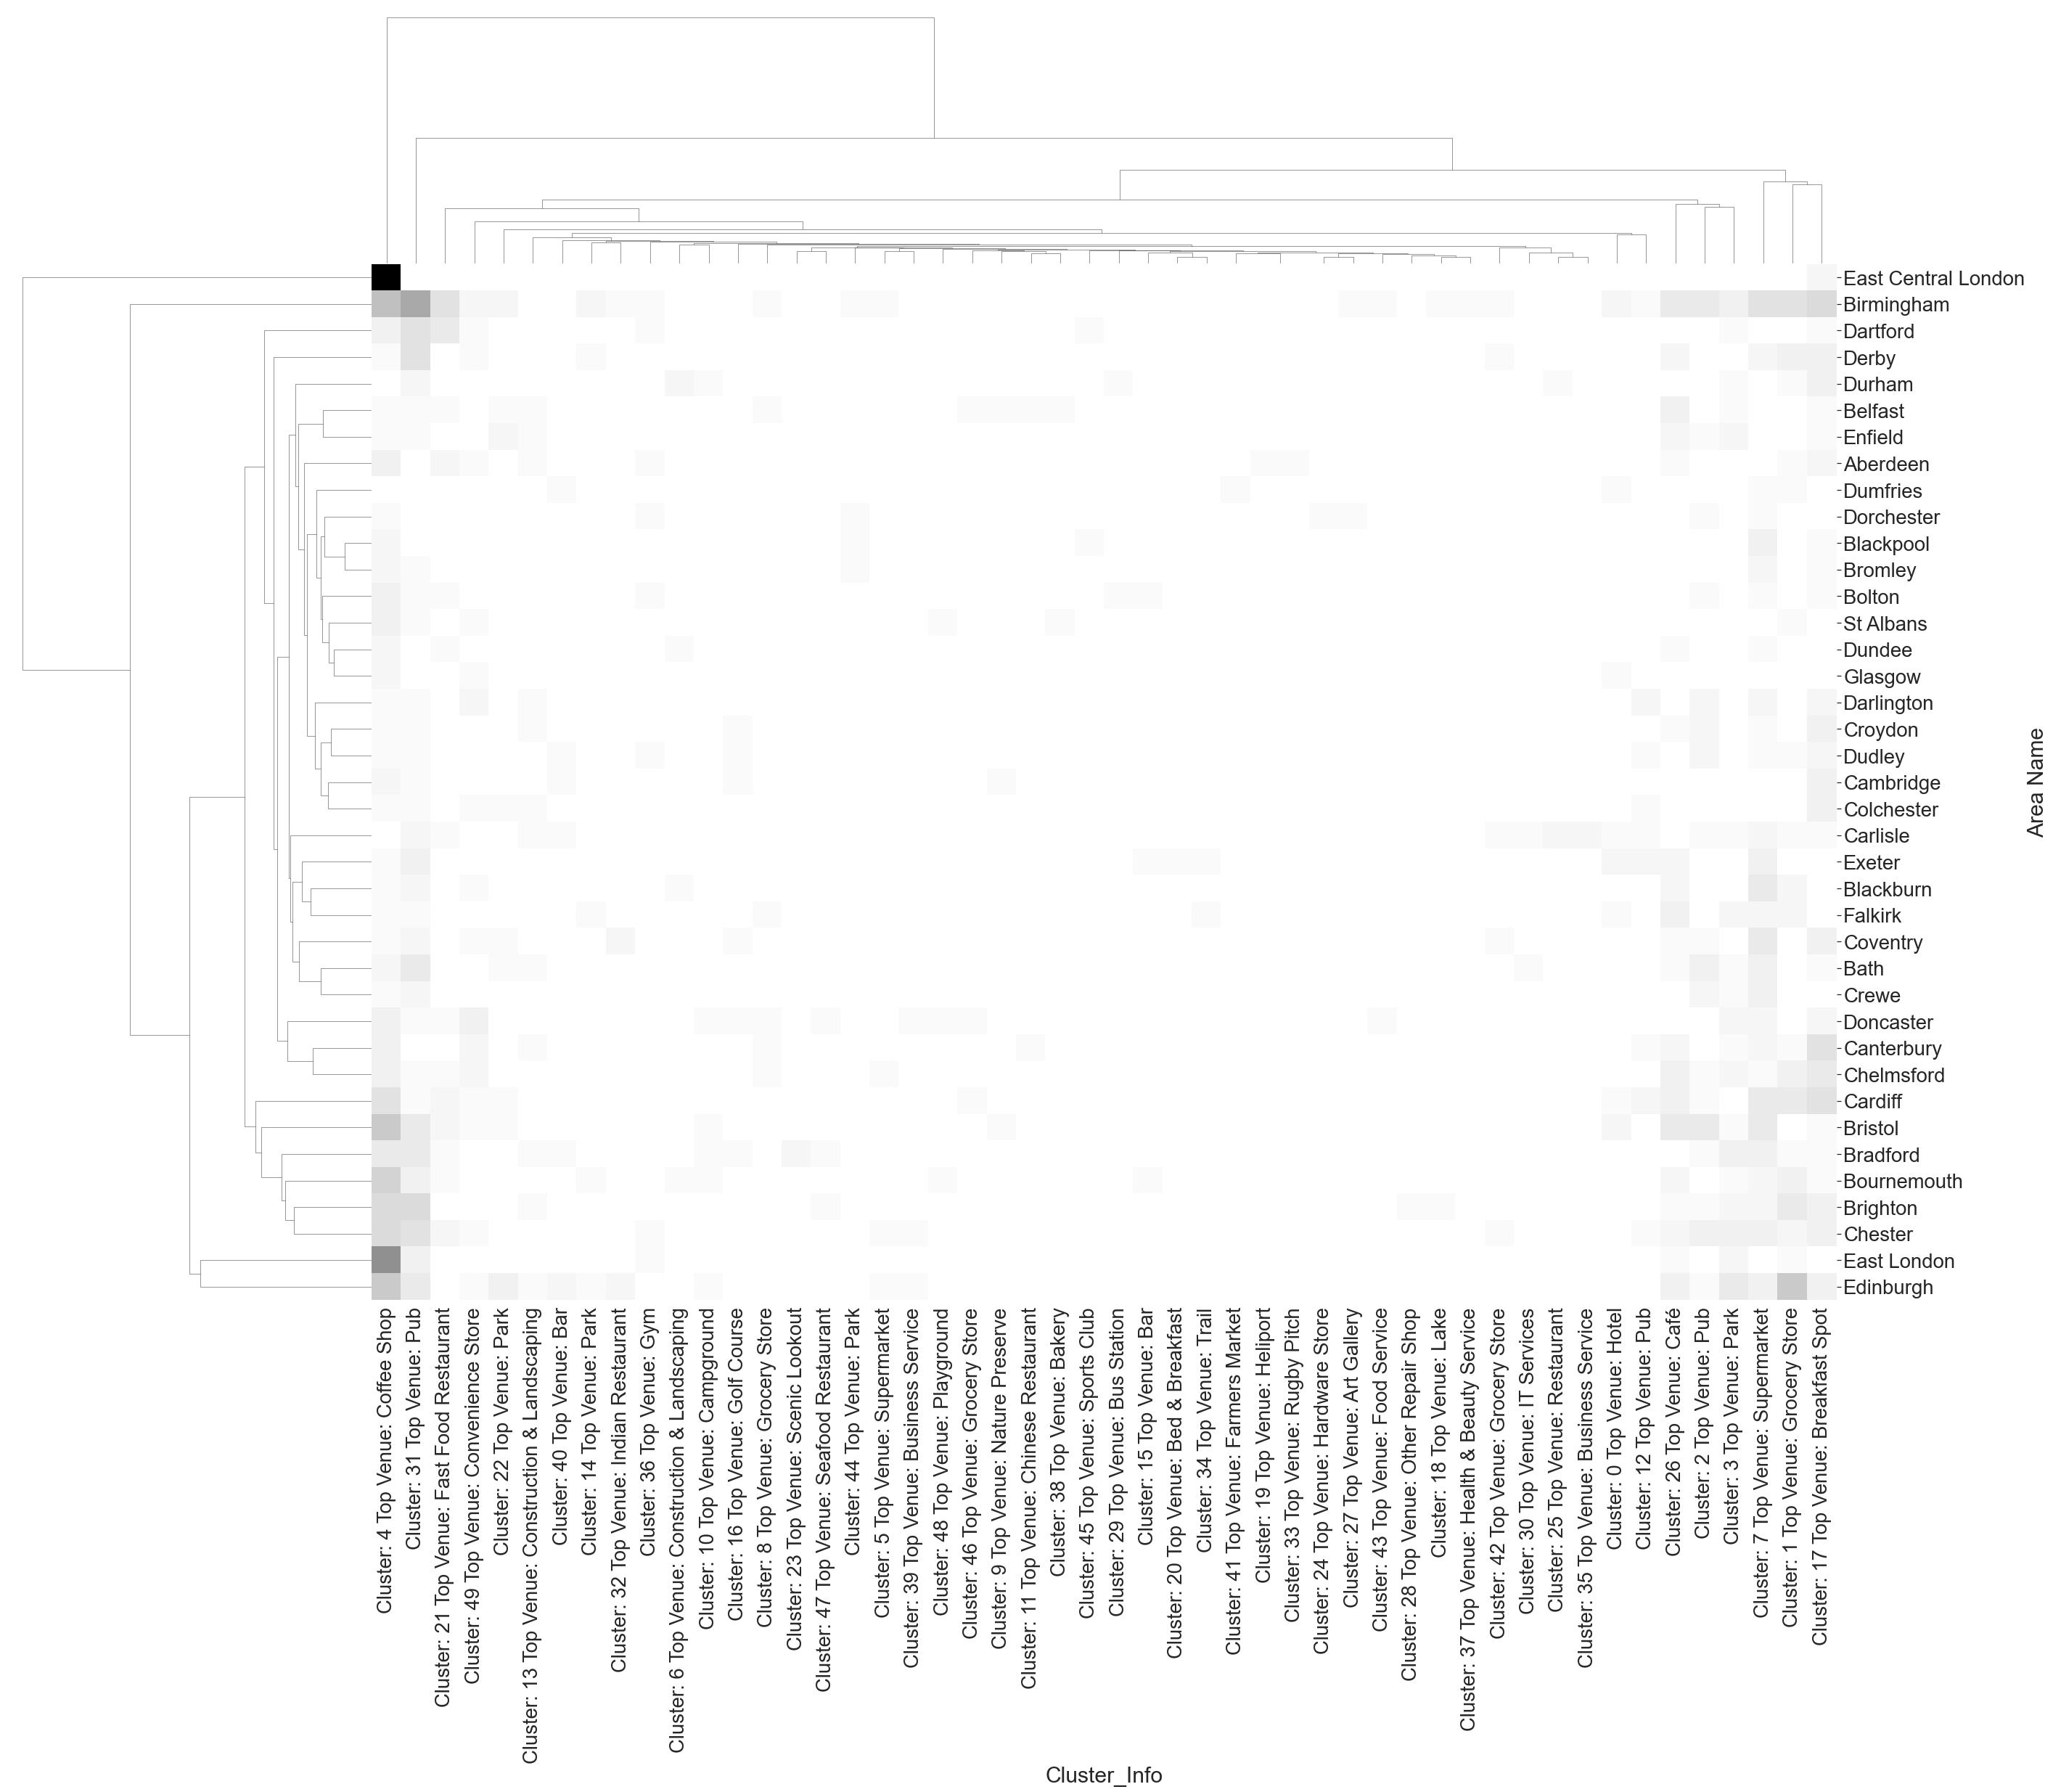

In [30]:
import seaborn as sns

# Group areas 
UK_Merged_hm = UK_Merged[['Area Name','Cluster Labels']]
UK_Merged_hm['Cluster Labels'].astype(str)
UK_Merged_hm = UK_Merged_hm.groupby(['Area Name','Cluster Labels']).size()
UK_Merged_hm = UK_Merged_hm.to_frame()
UK_Merged_hm.columns = ['Counts']

# Get top venue in clusters
ComVen_df = UK_Merged[['Cluster Labels','1st Most Common Venue']]
ComVen_df['Cluster Labels'].astype(str)
ComVen_df = ComVen_df.groupby(['Cluster Labels','1st Most Common Venue']).size()
ComVen_df = ComVen_df.to_frame()
ComVen_df.columns = ['Counts']
Clust_dict = {}
for i in ComVen_df.index.get_level_values(0).unique():
    m = max(ComVen_df.loc[[i]]['Counts'])
    pv = ComVen_df.loc[[float(i)]][ComVen_df.loc[[float(i)]]['Counts']==m].index.get_level_values(1)[0]
    Clust_dict[float(i)] = pv

Plot_Data = UK_Merged_hm
hm = []
for i,r in Plot_Data.iterrows():
    hm.append([i[0],i[1],Plot_Data.at[i,'Counts']])

df_hm = pd.DataFrame(hm,columns=['Area Name','Cluster Labels','Counts'])
df_hm['Cluster_Info'] = df_hm['Cluster Labels'].apply(lambda x: 'Cluster: '+str(int(x))+' Top Venue: '+str(Clust_dict[x]))
df_hm.drop('Cluster Labels',1,inplace=True)
hm_plot = df_hm.pivot(index='Area Name',columns='Cluster_Info',values='Counts')
Col_Sort_dict = {i:int(i.split(':')[1][1:3]) for i in hm_plot.columns.values}
Col_Sort = sorted(hm_plot.columns.values,key=Col_Sort_dict.get)
hm_plot = hm_plot[Col_Sort]
hm_plot.fillna(0,inplace=True)
# sns.set(rc={'figure.figsize':(15,15)})
# sns.heatmap(hm_plot,cmap='Greys')
# fig_siz = 5
# row_siz = hm_plot.shape[0]
# col_siz = len(hm_plot.columns.values)
# rat_row_siz = (row_siz+col_siz)/row_siz
# rat_col_siz = (row_siz+col_siz)/col_siz
sns.set(font_scale=2.5)
fig = sns.clustermap(hm_plot,cmap='Greys',figsize=(40,35))
fig.cax.set_visible(False)

### 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 0


In [ ]:
UK_Merged.loc[UK_Merged['Cluster Labels'] == 0, UK_Merged.columns[[1] + list(range(5, UK_Merged.shape[1]))]]

#### Cluster 1


In [ ]:
UK_Merged.loc[UK_Merged['Cluster Labels'] == 1, UK_Merged.columns[[1] + list(range(5, UK_Merged.shape[1]))]]

#### Cluster 2


In [ ]:
UK_Merged.loc[UK_Merged['Cluster Labels'] == 2, UK_Merged.columns[[1] + list(range(5, UK_Merged.shape[1]))]]

#### Cluster 3


In [ ]:
UK_Merged.loc[UK_Merged['Cluster Labels'] == 3, UK_Merged.columns[[1] + list(range(5, UK_Merged.shape[1]))]]

#### Cluster 4


In [ ]:
UK_Merged.loc[UK_Merged['Cluster Labels'] == 4, UK_Merged.columns[[1] + list(range(5, UK_Merged.shape[1]))]]

In [31]:
ComVen_df.loc[[4.0]]

Counts
Cluster Labels 1st Most Common Venue        
4.0            Bar                         5
               Café                        4
               Clothing Store              8
               Coffee Shop                34
               Convenience Store           4
               Discount Store              3
               Fireworks Store             1
               Grocery Store              12
               Gym / Fitness Center        3
               History Museum              1
               Hotel                       8
               Hotel Pool                  1
               IT Services                 1
               Indian Restaurant           5
               Italian Restaurant          3
               Market                      2
               Movie Theater               1
               Park                        2
               Pharmacy                    1
               Pizza Place                 2
               Platform                    2
               Pub                        28
               Sandwich Place              1
               Stationery Store            1
               Supermarket                 4

## Discussion

From the cluster information overlaid on the UK map, we can notice that data is missing for a few areas like Oxford and Norwich. This has to be taken into consideration when interpreting the results. As expected there are more postcodes in big cities like London, Birmingham, Liverpool and Manchester. 

Majority of areas in cities fall under cluster 4. The most popular venue in this cluster are coffee shops. 

If you like a big city atmosphere but want to relocate to a different area, results show that there are some towns which also are under cluster 4. These places can be good choices for you!

## Conclusion

- Data from Foursquare, freemaptools and Wikipedia were used to investigate the similarity of areas in the UK based on their neighbourhood.
- Information distribution was heterogenous with more data for big cities like London and Birmingham while few areas like Oxford, Peterborough and Norwich had no data.
- Most areas in cities were grouped under cluster 4 where the most popular venues were coffee shops.
- Results show that there are other towns outside big cities that also were categorized as cluster 4 indicating a similar surrounding. For example, we can observe from the cluster map that East London is similar to Edinburgh.
- This map can be used to evaluate the similarity of areas for various purposes such as relocation or starting a profitable business or buying properties.